In [1]:
import pandas as pd
import numpy as np
from numpy import inf
import matplotlib.pyplot as plt
import seaborn as sns
%load_ext autoreload
%autoreload 2

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, precision_recall_curve


from xgboost import XGBClassifier

import itertools
import random

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import practice_code as pc
import individual_stats as ind

from sklearn.model_selection import train_test_split, GridSearchCV

import warnings
warnings.filterwarnings('ignore')

In [2]:
clutch_time = pd.read_csv('CSV Files/clutch_time.csv')
clutch_time = pc.replace_nan(clutch_time)
clutch_time['total_blocks'] = (clutch_time['block'] != '')*1
clutch_time['assist_count'] = (clutch_time['assist'] != '')*1

In [3]:
reg = pd.read_csv('CSV Files/data_for_ids.csv')
ids = ind.add_ids(reg)

# Target (y_test 15-16 season)

In [4]:
first_target= clutch_time[clutch_time['data_set'] == '2015-2016 Regular Season']
first_target = ind.object_to_int(first_target, 'points')
assists = ind.assist_stats(first_target)
blks = ind.blk_stats(first_target)
names = ind.player_names(first_target)
first_target_stats = ind.merge_all(names, blks, assists, first_target)
first_target_stats = ind.get_per_game_stats(first_target_stats)
first_target_stats = ind.merge_ids(first_target_stats, ids)
first_target_stats = ind.add_league_avg(first_target_stats)


# X_test data (04-15)

In [5]:
test_clutch = clutch_time[clutch_time['data_set'] != '2015-2016 Regular Season']
test_clutch_time = pc.replace_nan(test_clutch)
test_clutch_time['total_blocks'] = (test_clutch_time['block'] != '')*1
test_clutch_time['assist_count'] = (test_clutch_time['assist'] != '')*1
player_stats_clutch = ind.object_to_int(test_clutch_time, 'points')
assists = ind.assist_stats(player_stats_clutch)
blks = ind.blk_stats(player_stats_clutch)
names = ind.player_names(player_stats_clutch)
test_clutch_stats = ind.merge_all(names, blks, assists, player_stats_clutch)
test_clutch_stats = ind.get_per_game_stats(test_clutch_stats)
test_clutch_stats = ind.merge_ids(test_clutch_stats, ids)
test_clutch_stats = ind.add_league_avg(test_clutch_stats)


# X_train data (04- 14 season)

In [6]:
train_clutch = clutch_time[clutch_time['data_set'] != '2015-2016 Regular Season']

In [7]:
train_clutch = train_clutch[train_clutch['data_set'] != '2014-2015 Regular Season']

In [8]:
x_data = ind.object_to_int(train_clutch, 'points')
assists = ind.assist_stats(x_data)
blks = ind.blk_stats(x_data)
names = ind.player_names(x_data)
x_train_stats = ind.merge_all(names, blks, assists, x_data)
x_train_stats = ind.get_per_game_stats(x_train_stats)
x_train_stats = ind.merge_ids(x_train_stats, ids)
x_train_stats = ind.add_league_avg(x_train_stats)

# y_train data (14-15 season)

In [9]:
y_data = clutch_time[clutch_time['data_set'] == '2014-2015 Regular Season']
y_data = ind.object_to_int(y_data, 'points')
assists = ind.assist_stats(y_data)
blks = ind.blk_stats(y_data)
names = ind.player_names(y_data)
y_train_stats = ind.merge_all(names, blks, assists, y_data)
y_train_stats = ind.get_per_game_stats(y_train_stats)
y_train_stats = ind.merge_ids(y_train_stats, ids)
y_train_stats = ind.add_league_avg(y_train_stats)

In [10]:
turnover_data = pd.read_csv('CSV Files/reg_turnovers.csv')

In [11]:
turn_y_train = turnover_data[turnover_data['data_set'] == '2014-2015 Regular Season']
first_target_turn = turnover_data[turnover_data['data_set'] == '2015-2016 Regular Season']

In [12]:
x_test_turn = turnover_data[turnover_data['data_set']!= '2015-2016 Regular Season']

In [13]:
x_train_turn = turnover_data[turnover_data['data_set']!= '2015-2016 Regular Season']

In [14]:
x_train_turn = x_train_turn[x_train_turn['data_set']!= '2014-2015 Regular Season']

In [15]:
x_test_turn['pts_difference'] = x_test_turn['away_score'] - x_test_turn['home_score']
x_test_turn = pc.clutch_moment(x_test_turn)
x = x_test_turn.groupby('player').count()
x_test_turn = x[['event_type']]
x_test_turn.reset_index(level=0, inplace=True)
x_test_turn = x_test_turn.rename(columns={'event_type':'total_turnovers'})
test_clutch_stats = pd.merge(test_clutch_stats,x_test_turn,on='player', how = 'left')
test_clutch_stats = test_clutch_stats.fillna(0)
test_clutch_stats['TPG'] = round(test_clutch_stats['total_turnovers'] / test_clutch_stats['total_games'],2)


In [16]:
x_train_turn['pts_difference'] = x_train_turn['away_score'] - x_train_turn['home_score']
x_train_turn = pc.clutch_moment(x_train_turn)
x = x_train_turn.groupby('player').count()
x_train_turn = x[['event_type']]
x_train_turn.reset_index(level=0, inplace=True)
x_train_turn = x_train_turn.rename(columns={'event_type':'total_turnovers'})
x_train_stats = pd.merge(x_train_stats,x_train_turn,on='player', how = 'left')
x_train_stats = x_train_stats.fillna(0)
x_train_stats['TPG'] = round(x_train_stats['total_turnovers'] / x_train_stats['total_games'],2)


In [17]:
first_target_turn['pts_difference'] = first_target_turn['away_score'] - first_target_turn['home_score']
first_target_turn = pc.clutch_moment(first_target_turn)
x = first_target_turn.groupby('player').count()
first_target_turn = x[['event_type']]
first_target_turn.reset_index(level=0, inplace=True)
first_target_turn = first_target_turn.rename(columns={'event_type':'total_turnovers'})
first_target_stats = pd.merge(first_target_stats,first_target_turn,on='player', how = 'left')
first_target_stats = first_target_stats.fillna(0)
first_target_stats['TPG'] = round(first_target_stats['total_turnovers'] / first_target_stats['total_games'],2)


In [18]:
turn_y_train['pts_difference'] = turn_y_train['away_score'] - turn_y_train['home_score']
turn_y_train = pc.clutch_moment(turn_y_train)
x = turn_y_train.groupby('player').count()
turn_y_train = x[['event_type']]
turn_y_train.reset_index(level=0, inplace=True)
turn_y_train = turn_y_train.rename(columns={'event_type':'total_turnovers'})
y_train_stats = pd.merge(y_train_stats,turn_y_train,on='player', how = 'left')
y_train_stats = y_train_stats.fillna(0)
y_train_stats['TPG'] = round(y_train_stats['total_turnovers'] / y_train_stats['total_games'],2)


In [19]:
x_train_stats = ind.add_scores(x_train_stats)
first_target_stats = ind.add_scores(first_target_stats)
y_train_stats = ind.add_scores(y_train_stats)
test_clutch_stats = ind.add_scores(test_clutch_stats)

In [20]:
x_train_stats = ind.is_clutch(x_train_stats)
first_target_stats = ind.is_clutch(first_target_stats)
y_train_stats = ind.is_clutch(y_train_stats)
test_clutch_stats = ind.is_clutch(test_clutch_stats)

In [21]:
players = x_train_stats[['player']]
y_train_stats = y_train_stats.merge(players, on='player')

x = y_train_stats[['player']]
x_train_stats = x_train_stats.merge(x, on='player')


In [22]:
d = first_target_stats[['player']]
test_clutch_stats = test_clutch_stats.merge(d, on='player')

y = test_clutch_stats[['player']]
first_target_stats = first_target_stats.merge(y, on='player')


In [31]:
# x_train = x_train_stats[['shots_missed', '3pt_shots', 'assist_count', 'ORPG', 'RPG', 'FT_score','total_score']]
y_train = y_train_stats['is_clutch']
x_train = x_train_stats[['TPG', 'med/hard_fg%', 'total_rebound', '3pt', 'FT_made', 'Hard_2Score', '2pt%', 'off_rebound', 
'Easy_2Score', 'RPG', 'med/hard_attempts', 'total_score', 'assist_count',
'FT_score', 'FT_missed', 'ORPG', 'shots_missed', '3pt_score']]

In [32]:
#x_test = test_clutch_stats[['shots_missed', '3pt_shots', 'assist_count', 'ORPG', 'RPG', 'FT_score','total_score']]
y_test = first_target_stats['is_clutch']
x_test = test_clutch_stats[['TPG', 'med/hard_fg%', 'total_rebound', '3pt', 'FT_made', 'Hard_2Score', '2pt%', 'off_rebound', 
'Easy_2Score', 'RPG', 'med/hard_attempts', 'total_score', 'assist_count',
'FT_score', 'FT_missed', 'ORPG', 'shots_missed', '3pt_score']]

In [33]:
modelGB = GradientBoostingClassifier()
modelGB.fit(x_train, y_train)
predGB= modelGB.predict(x_test)

In [34]:
f1_score(y_test, predGB)

0.08695652173913045

In [35]:
accuracy_score(y_test, predGB)

0.7871621621621622

In [36]:
precision_score(y_test, predGB)

0.2

In [37]:
recall_score(y_test, predGB)

0.05555555555555555

In [84]:
x = modelGB.feature_importances_
x

array([4.30190634e-02, 4.37355193e-02, 1.19024038e-02, 1.09112056e-02,
       3.29636540e-02, 1.99971554e-02, 2.36115469e-02, 5.64867708e-02,
       5.64213629e-03, 4.61497290e-02, 4.06471353e-02, 6.25588426e-02,
       7.52596392e-03, 3.06179149e-02, 1.89997874e-02, 3.08355508e-02,
       5.91262213e-02, 2.75560352e-02, 5.43505828e-02, 1.99549560e-02,
       6.71881115e-03, 3.63515267e-02, 2.13413649e-02, 2.74444138e-02,
       2.82314801e-02, 2.46886620e-02, 1.96580199e-02, 1.07188004e-02,
       2.96836224e-02, 5.18514178e-02, 1.51074383e-02, 1.73876583e-02,
       3.19321636e-02, 2.06321084e-02, 1.16353958e-02, 2.49417875e-05])

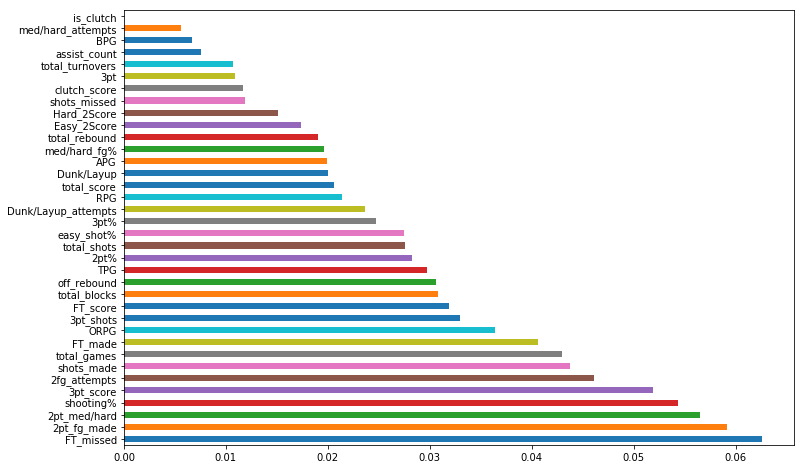

In [85]:
ig, axs = plt.subplots(1,0, figsize=(12,8))
(pd.Series(x, index=x_test.columns)
   .nlargest(36)
   .plot(kind='barh'))

In [45]:
parameters = {'learning_rate': [.22,.2], 'n_estimators': [50,150,100], 'max_depth': [12], 
                                                               'min_samples_leaf': [1]}

In [46]:
gs = GridSearchCV(GradientBoostingClassifier(), parameters, cv=10, scoring='f1')
gs.fit(x_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.22, 0.2], 'n_estimators': [50, 150, 100], 'max_depth': [12], 'min_samples_leaf': [1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [47]:
gs.best_params_

{'learning_rate': 0.2,
 'max_depth': 12,
 'min_samples_leaf': 1,
 'n_estimators': 100}

In [48]:
gs.best_score_

0.33408522260981277

In [36]:

36.78
{'learning_rate': 0.25,
 'max_depth': 12,
 'min_samples_leaf': 1,
 'n_estimators': 10}



f1 30.56

params
{'learning_rate': 0.2,
 'max_depth': 10,
 'min_samples_leaf': 1,
 'n_estimators': 10}

[mean: 0.00000, std: 0.00000, params: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 1, 'n_estimators': 10},
 mean: 0.22293, std: 0.22795, params: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 1, 'n_estimators': 100},
 mean: 0.20442, std: 0.27244, params: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 1, 'n_estimators': 250},
 mean: 0.26128, std: 0.27502, params: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 1, 'n_estimators': 500},
 mean: 0.00000, std: 0.00000, params: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 3, 'n_estimators': 10},
 mean: 0.15420, std: 0.22690, params: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 3, 'n_estimators': 100},
 mean: 0.23115, std: 0.28604, params: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 3, 'n_estimators': 250},
 mean: 0.25098, std: 0.21961, params: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 3, 'n_estimators': 500},
 mean: 0.02998, std: 0.085

In [38]:
modelFX = XGBClassifier()
modelFX.fit(x_train, y_train)
y_predFX=modelFX.predict(x_test)
print("recall: %.5f%%" % recall_score(y_test, y_predFX))
print("f1: %.5f%%" % f1_score(y_test, y_predFX))
print("Accuracy: %.5f%%" % accuracy_score(y_test, y_predFX))
print("precision: %.5f%%" % precision_score(y_test, y_predFX))

recall: 0.11111%
f1: 0.16438%
Accuracy: 0.79392%
precision: 0.31579%
